In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

--- Loading Data from Custom CSV Files ---
Successfully read: .\Quant_PS_Dataset\Apple_stock_data.csv
Columns renamed for AAPL based on expected order.
Data loaded and prepared for AAPL
Successfully read: .\Quant_PS_Dataset\Facebook_stock_data.csv
Columns renamed for META based on expected order.
Data loaded and prepared for META
Successfully read: .\Quant_PS_Dataset\Tesla_stock_data.csv
Columns renamed for TSLA based on expected order.
Data loaded and prepared for TSLA
Successfully read: .\Quant_PS_Dataset\JP Morgan_stock_data.csv
Columns renamed for JPM based on expected order.
Data loaded and prepared for JPM
Successfully read: .\Quant_PS_Dataset\Amazon_stock_data.csv
Columns renamed for AMZN based on expected order.
Data loaded and prepared for AMZN

Successfully loaded data for: ['AAPL', 'META', 'TSLA', 'JPM', 'AMZN']
Calculating indicators for AAPL...
Calculating indicators for META...
Calculating indicators for TSLA...
Calculating indicators for JPM...
Calculating indicators for

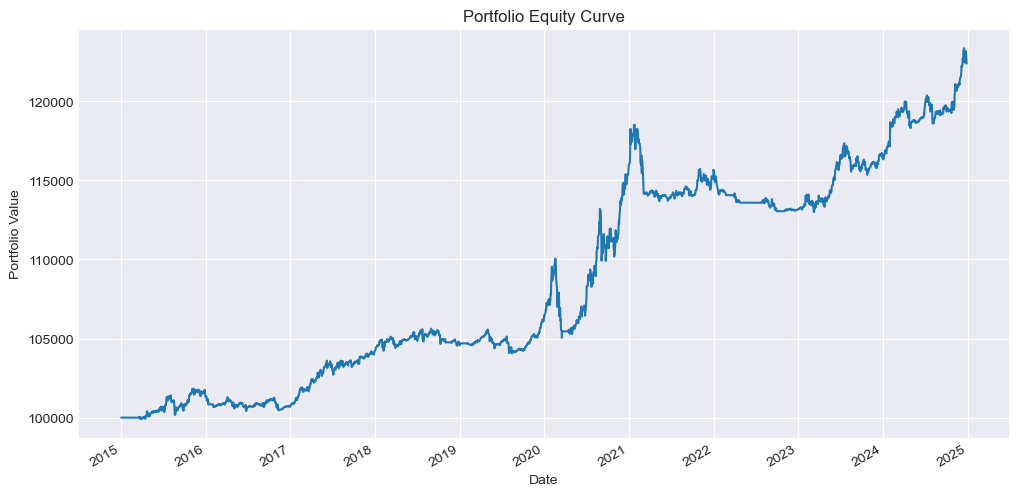

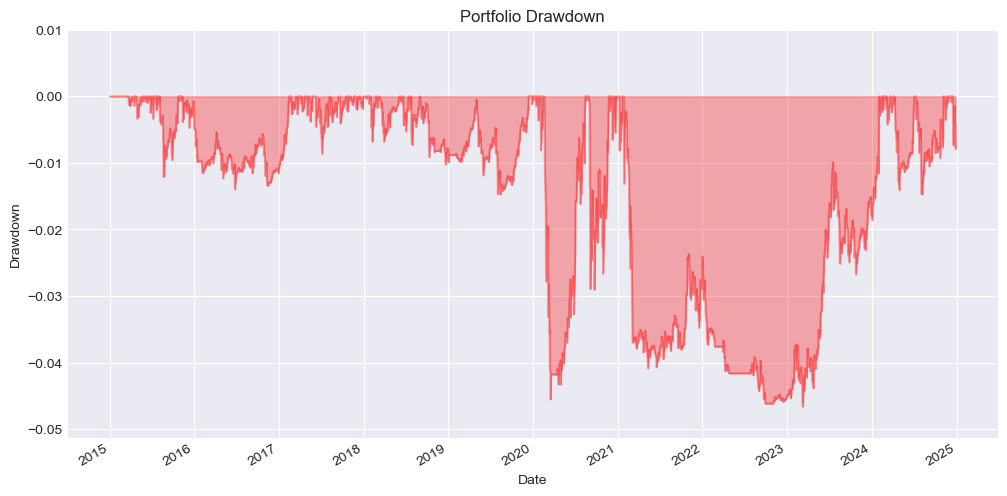

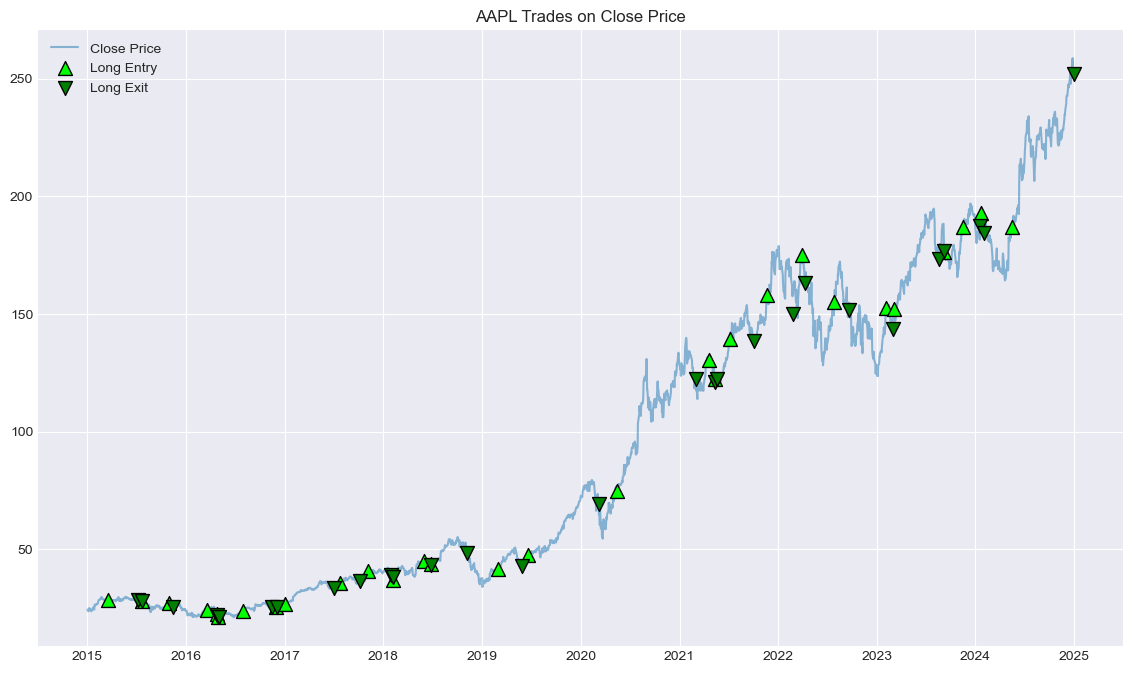


--- All Trades ---
    Ticker  EntryDate  EntryPrice   ExitDate   ExitPrice Position  Size          PNL ExitReason
0     AAPL 2015-03-19   28.474283 2015-07-07   28.187311     Long    70   -22.061155   EMACross
1     AAPL 2015-07-22   28.081905 2015-07-23   28.068453     Long    71    -2.947990   EMACross
2     AAPL 2015-10-30   26.920435 2015-11-13   25.515823     Long    74  -105.829444   StopLoss
3     AAPL 2016-03-21   24.091089 2016-04-27   21.836890     Long    82  -186.634945   StopLoss
4     AAPL 2016-04-27   22.250881 2016-04-29   21.200518     Long    89   -95.369160   StopLoss
5     AAPL 2016-04-29   21.322811 2016-05-02   21.300060     Long    91    -4.008633   EMACross
6     AAPL 2016-07-29   23.848713 2016-11-16   25.437778     Long    82   128.217477   EMACross
7     AAPL 2016-12-01   25.322144 2016-12-02   25.416965     Long    77     5.344182   EMACross
8     AAPL 2017-01-03   26.862427 2017-07-03   33.469219     Long    73   479.852596   EMACross
9     AAPL 2017-07-2

In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import pandas_ta as ta # For technical indicators including Heikin-Ashi
import matplotlib.pyplot as plt
import os # To construct file paths if needed
import warnings

warnings.filterwarnings('ignore') # Hide common warnings

# 2. Configuration

# --- File Paths (As provided by user) ---
csv_directory = '.\Quant_PS_Dataset'
csv_files = {
    'AAPL': os.path.join(csv_directory, 'Apple_stock_data.csv'),
    'META': os.path.join(csv_directory, 'Facebook_stock_data.csv'),
    'TSLA': os.path.join(csv_directory, 'Tesla_stock_data.csv'),
    'JPM': os.path.join(csv_directory, 'JP Morgan_stock_data.csv'),
    'AMZN': os.path.join(csv_directory, 'Amazon_stock_data.csv'),
}
tickers = list(csv_files.keys())

# --- Strategy Parameters (Adjust as needed) ---
ema_short_period = 20
ema_long_period = 50
adx_period = 14
adx_threshold = 25
atr_period = 14
atr_stop_multiplier = 2.0
volume_sma_period = 20
initial_capital = 100000
position_size_pct = 0.10 # Allocate 10% of portfolio equity per trade initially
commission_pct = 0.001 # Example commission per trade (0.1%)

# Define the standard column names we expect *after* processing the custom CSV format
standard_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
date_column_name = 'Date' # The standard name we'll use for the index internally


# 3. Data Acquisition from Custom CSV Files (MODIFIED SECTION)
data_dict = {}
valid_tickers = [] # Keep track of tickers successfully loaded

print("--- Loading Data from Custom CSV Files ---")
for ticker in tickers:
    file_path = csv_files.get(ticker)
    if not file_path:
        print(f"No file path defined for {ticker}. Skipping.")
        continue

    try:
        # === MODIFICATION START ===
        # Read the CSV, specifying that the actual header is on the 3rd row (index 2)
        df = pd.read_csv(file_path, header=2)
        print(f"Successfully read: {file_path}")

        # Assign correct column names based on the known format from row 1 of the file
        # The order corresponds to: Date, Close, High, Low, Open, Volume
        expected_order_from_file = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
        if len(df.columns) == len(expected_order_from_file):
            df.columns = expected_order_from_file
            print(f"Columns renamed for {ticker} based on expected order.")
        else:
            print(f"ERROR: Column count mismatch in {ticker}.csv. Expected {len(expected_order_from_file)}, found {len(df.columns)}. Skipping.")
            continue
        # === MODIFICATION END ===

        # --- Data Cleaning and Preparation (Uses standard column names now) ---
        # 1. Column names are already set above.

        # 2. Check for Date column (using the standard internal name)
        if date_column_name not in df.columns:
            print(f"ERROR: Date column '{date_column_name}' not found after processing {ticker}.csv. Skipping.")
            continue

        # 3. Convert Date column to datetime and set as index
        try:
            df[date_column_name] = pd.to_datetime(df[date_column_name])
            df.set_index(date_column_name, inplace=True)
            df.sort_index(inplace=True) # Ensure data is chronological
        except Exception as e:
            print(f"ERROR: Could not process date column for {ticker}: {e}. Skipping.")
            continue

        # 4. Check for required standard OHLCV columns
        missing_cols = [col for col in standard_columns if col not in df.columns]
        if missing_cols:
            print(f"ERROR: Missing required standard columns in {ticker}.csv after processing: {missing_cols}. Skipping.")
            continue

        # 5. Ensure numeric types (important for calculations)
        for col in standard_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # 6. Handle missing values (e.g., fill forward or drop)
        initial_len = len(df)
        df.dropna(subset=standard_columns, inplace=True) # Drop rows where OHLCV is missing
        if len(df) < initial_len:
             print(f"Dropped {initial_len - len(df)} rows with NaNs in required columns for {ticker}.")

        if df.empty:
            print(f"Data for {ticker} is empty after cleaning. Skipping.")
            continue
        # --- End Data Cleaning ---

        data_dict[ticker] = df
        valid_tickers.append(ticker)
        print(f"Data loaded and prepared for {ticker}")

    except FileNotFoundError:
        print(f"ERROR: File not found: {file_path}. Skipping {ticker}.")
    except Exception as e:
        print(f"ERROR: Could not read or process file {file_path} for {ticker}: {e}. Skipping.")

print(f"\nSuccessfully loaded data for: {valid_tickers}")
if not valid_tickers:
     print("\nERROR: No valid data loaded. Exiting.")
     # exit() # Or handle appropriately


# --- Helper Function for Heikin-Ashi & Indicators (Unchanged) ---
def calculate_indicators(df):
    """Calculates Heikin-Ashi candles and technical indicators."""
    # Calculate Heikin-Ashi using pandas_ta
    # Ensure the required columns ('Open', 'High', 'Low', 'Close') exist and are numeric
    required_ohlc = ['Open', 'High', 'Low', 'Close']
    if not all(col in df.columns for col in required_ohlc):
        print("Warning: Missing required OHLC columns for Heikin-Ashi calculation.")
        return df # Return original df if columns missing

    try:
        # Explicitly pass OHLC columns to ta.ha
        ha_df = ta.ha(open_=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])
        # Append the HA columns to the original DataFrame
        for col in ha_df.columns:
             df[col] = ha_df[col]
    except Exception as e:
        print(f"Error calculating Heikin-Ashi: {e}. Proceeding without HA columns.")


    # Ensure HA columns exist before calculating indicators on them
    ha_cols = ['HA_open', 'HA_high', 'HA_low', 'HA_close']
    if not all(col in df.columns for col in ha_cols):
         print(f"Warning: Heikin-Ashi columns not found after ta.ha(). Check pandas_ta. Using regular OHLC for indicators.")
         # Fallback: Use regular OHLC if HA calculation failed
         ohlc_for_indicators = {
             'high': df['High'],
             'low': df['Low'],
             'close': df['Close']
         }
    else:
         ohlc_for_indicators = {
             'high': df['HA_high'],
             'low': df['HA_low'],
             'close': df['HA_close']
         }


    # Calculate Indicators based on selected OHLC data (HA preferably)
    df[f'HA_EMA_{ema_short_period}'] = ta.ema(ohlc_for_indicators['close'], length=ema_short_period)
    df[f'HA_EMA_{ema_long_period}'] = ta.ema(ohlc_for_indicators['close'], length=ema_long_period)

    # Calculate ADX using pandas_ta on selected High, Low, Close
    adx_df = ta.adx(ohlc_for_indicators['high'], ohlc_for_indicators['low'], ohlc_for_indicators['close'], length=adx_period)
    if adx_df is not None and f'ADX_{adx_period}' in adx_df.columns:
        df['ADX'] = adx_df[f'ADX_{adx_period}']
    else:
        print("Warning: Could not calculate ADX. Filling with NaN.")
        df['ADX'] = np.nan

    # Calculate ATR using pandas_ta on selected High, Low, Close
    atr_df = ta.atr(ohlc_for_indicators['high'], ohlc_for_indicators['low'], ohlc_for_indicators['close'], length=atr_period)
    if atr_df is not None: # pandas_ta atr returns a Series directly
        df['ATR'] = atr_df
    else:
         print("Warning: Could not calculate ATR. Filling with NaN.")
         df['ATR'] = np.nan


    # Calculate Volume SMA (using original 'Volume')
    df['Volume_SMA'] = ta.sma(df['Volume'], length=volume_sma_period)

    return df

# 4. Calculate Indicators for all stocks
indicator_data = {}
tickers_with_indicators = []
for ticker in valid_tickers:
    print(f"Calculating indicators for {ticker}...")
    indicator_data[ticker] = calculate_indicators(data_dict[ticker].copy())
    if indicator_data[ticker].empty:
        print(f"Indicator calculation resulted in empty DataFrame for {ticker}. Skipping.")
    # Check if essential calculated columns exist and have non-NA values later
    elif indicator_data[ticker][[f'HA_EMA_{ema_short_period}', f'HA_EMA_{ema_long_period}', 'ADX', 'ATR']].isnull().all().all():
        print(f"Essential indicators are all NaN for {ticker}. Skipping backtest.")
    else:
         tickers_with_indicators.append(ticker)


# 5. Backtesting Engine (Mostly Unchanged, PNL calc refined)
def run_backtest(data, ticker, capital, pos_pct, commission):
    """Runs the momentum backtest for a single stock."""
    cash = capital
    equity = [capital] # Start with initial capital
    position = 0 # Shares held
    entry_price = 0
    entry_date = None
    stop_loss_price = 0
    trades = [] # List to store trade details

    signal_col_short = f'HA_EMA_{ema_short_period}'
    signal_col_long = f'HA_EMA_{ema_long_period}'
    adx_col = 'ADX'
    atr_col = 'ATR'
    vol_sma_col = 'Volume_SMA'

    print(f"\nRunning backtest for {ticker}...")

    # Iterate through data
    for i in range(1, len(data)): # Start from 1 to check previous state
        current_date = data.index[i]
        # Check if essential data for the current step is available
        if pd.isna(data['Close'].iloc[i]) or pd.isna(data['Open'].iloc[i]) or pd.isna(data['Low'].iloc[i]) or pd.isna(data['High'].iloc[i]):
             current_holding_value = position * data['Close'].iloc[i-1] if position != 0 and not pd.isna(data['Close'].iloc[i-1]) else 0
             equity.append(cash + current_holding_value)
             continue

        current_close = data['Close'].iloc[i]
        current_open = data['Open'].iloc[i]
        current_high = data['High'].iloc[i]
        current_low = data['Low'].iloc[i]
        current_volume = data['Volume'].iloc[i]
        current_atr = data[atr_col].iloc[i]

        # --- Check Stop Loss ---
        if position > 0:
            if not pd.isna(stop_loss_price) and current_low <= stop_loss_price:
                exit_price = min(current_open, stop_loss_price)
                if pd.isna(exit_price): exit_price = current_low

                if not pd.isna(entry_price):
                    exit_value = exit_price * position
                    entry_value = entry_price * position
                    gross_pnl = exit_value - entry_value
                    commission_cost = exit_value * commission # Commission on exit value
                    net_pnl = gross_pnl - commission_cost
                    cash += exit_value * (1 - commission) # Cash received after commission
                    trades.append({
                         'Ticker': ticker, 'EntryDate': entry_date, 'EntryPrice': entry_price,
                         'ExitDate': current_date, 'ExitPrice': exit_price, 'Position': 'Long',
                         'Size': position, 'PNL': net_pnl, 'ExitReason': 'StopLoss'
                    })
                    print(f"{current_date} {ticker}: Stop Loss hit (Long) @ {exit_price:.2f}, PNL: {net_pnl:.2f}")
                else:
                    cash += exit_price * position * (1 - commission) # Adjust cash but PNL unknown
                    print(f"{current_date} {ticker}: Stop Loss hit (Long) @ {exit_price:.2f}, PNL unknown (missing entry price)")

                position = 0
                entry_price = 0
                stop_loss_price = 0

        # --- Define Signals based on previous day's data ---
        required_signal_cols = [signal_col_short, signal_col_long, adx_col, vol_sma_col, 'Volume', atr_col]
        if i == 0 or data[required_signal_cols].iloc[i-1].isnull().any():
             current_holding_value = position * current_close if position != 0 else 0
             equity.append(cash + current_holding_value)
             continue

        ema_short_prev = data[signal_col_short].iloc[i-1]
        ema_long_prev = data[signal_col_long].iloc[i-1]
        adx_prev = data[adx_col].iloc[i-1]
        volume_prev = data['Volume'].iloc[i-1]
        vol_sma_prev = data[vol_sma_col].iloc[i-1]
        atr_prev = data[atr_col].iloc[i-1]

        valid_atr_prev = atr_prev is not None and not pd.isna(atr_prev) and atr_prev > 0

        long_signal = (ema_short_prev > ema_long_prev and
                       adx_prev > adx_threshold and
                       volume_prev > vol_sma_prev)

        long_exit_signal = (ema_short_prev < ema_long_prev)

        # --- Execute Trades ---
        entry_exit_price = current_close # Simple execution at close

        if position == 0: # No position
            if long_signal and valid_atr_prev:
                portfolio_value = equity[-1]
                trade_value = portfolio_value * pos_pct
                shares_to_buy = int(trade_value / entry_exit_price)
                entry_cost = shares_to_buy * entry_exit_price
                commission_cost = entry_cost * commission
                required_cash = entry_cost + commission_cost

                if shares_to_buy > 0 and cash >= required_cash:
                    entry_price = entry_exit_price
                    entry_date = current_date
                    position = shares_to_buy
                    cash -= required_cash # Deduct cost including commission
                    stop_loss_price = entry_price - (atr_prev * atr_stop_multiplier)
                    print(f"{current_date} {ticker}: Enter Long @ {entry_price:.2f}, Size: {position}, SL: {stop_loss_price:.2f}")

        elif position > 0: # Holding Long
            if long_exit_signal:
                exit_price = entry_exit_price
                exit_value = exit_price * position
                entry_value = entry_price * position
                gross_pnl = exit_value - entry_value
                commission_cost = exit_value * commission # Commission on exit value
                net_pnl = gross_pnl - commission_cost
                cash += exit_value * (1 - commission) # Cash received after commission
                trades.append({
                    'Ticker': ticker, 'EntryDate': entry_date, 'EntryPrice': entry_price,
                    'ExitDate': current_date, 'ExitPrice': exit_price, 'Position': 'Long',
                    'Size': position, 'PNL': net_pnl, 'ExitReason': 'EMACross'
                })
                print(f"{current_date} {ticker}: Exit Long (EMA Cross) @ {exit_price:.2f}, PNL: {net_pnl:.2f}")
                position = 0
                entry_price = 0
                stop_loss_price = 0

        # Update Equity
        current_holding_value = position * current_close if position != 0 else 0
        equity.append(cash + current_holding_value)

    # Close any open position at the end
    last_valid_close = data['Close'].iloc[-1]
    last_valid_date = data.index[-1]
    if pd.isna(last_valid_close):
         last_valid_close = data['Close'].dropna().iloc[-1]
         last_valid_date = data['Close'].dropna().index[-1]

    if position > 0 and not pd.isna(entry_price):
        exit_price = last_valid_close
        exit_value = exit_price * position
        entry_value = entry_price * position
        gross_pnl = exit_value - entry_value
        commission_cost = exit_value * commission # Commission on exit value
        net_pnl = gross_pnl - commission_cost
        cash += exit_value * (1 - commission) # Cash received after commission
        trades.append({
            'Ticker': ticker, 'EntryDate': entry_date, 'EntryPrice': entry_price,
            'ExitDate': last_valid_date, 'ExitPrice': exit_price, 'Position': 'Long',
            'Size': position, 'PNL': net_pnl, 'ExitReason': 'End'
        })
        print(f"{last_valid_date} {ticker}: Exit Long (End) @ {exit_price:.2f}, PNL: {net_pnl:.2f}")
        position = 0
    elif position > 0 and pd.isna(entry_price):
         cash += last_valid_close * position * (1-commission) # Assume commission on exit anyway
         print(f"{last_valid_date} {ticker}: Exit Long (End) @ {last_valid_close:.2f}, PNL unknown (missing entry price)")
         position = 0

    # Final equity update (should reflect final cash)
    # Adjust index for equity_df to match data index length
    equity_df = pd.DataFrame({'Equity': equity[1:]}, index=data.index[range(len(equity)-1)])
    trades_df = pd.DataFrame(trades)
    return equity_df, trades_df


# 6. Run Backtests for all Stocks (Mostly Unchanged)
all_equity = {}
all_trades = {}

num_stocks_to_trade = len(tickers_with_indicators)
if num_stocks_to_trade == 0:
     print("\nERROR: No stocks remaining after indicator calculation. Cannot run backtest.")
else:
    capital_per_stock = initial_capital / num_stocks_to_trade
    for ticker in tickers_with_indicators:
        if ticker in indicator_data and not indicator_data[ticker].empty:
            equity_df, trades_df = run_backtest(
                indicator_data[ticker],
                ticker,
                capital_per_stock,
                position_size_pct,
                commission_pct
            )
            all_equity[ticker] = equity_df
            all_trades[ticker] = trades_df
        else:
            print(f"Skipping backtest for {ticker} due to missing or empty data.")

# Combine results (Mostly Unchanged, ensure index handling is robust)
if all_equity:
    common_index = None
    for ticker, eq_df in all_equity.items():
         # Ensure the index is a DatetimeIndex for intersection
         if not isinstance(eq_df.index, pd.DatetimeIndex):
             print(f"Warning: Index for {ticker} is not DatetimeIndex. Attempting conversion.")
             try:
                 eq_df.index = pd.to_datetime(eq_df.index)
             except Exception as e:
                 print(f"Error converting index for {ticker}: {e}. Skipping this stock for portfolio calculation.")
                 continue # Skip if index conversion fails

         if common_index is None:
             common_index = eq_df.index
         else:
             common_index = common_index.intersection(eq_df.index)

    portfolio_equity_list = []
    if common_index is not None and not common_index.empty:
        for ticker, eq_df in all_equity.items():
            if not isinstance(eq_df.index, pd.DatetimeIndex): # Skip if index wasn't converted
                 continue
            # Reindex, forward fill, and fill initial NaNs with allocated capital
            reindexed_df = eq_df.reindex(common_index).ffill()
            reindexed_df['Equity'] = reindexed_df['Equity'].fillna(capital_per_stock) # Fill remaining NaNs (usually at start)
            portfolio_equity_list.append(reindexed_df['Equity'])

        if portfolio_equity_list:
            portfolio_equity = pd.concat(portfolio_equity_list, axis=1).sum(axis=1)
            portfolio_equity.name = 'Equity'
        else:
            portfolio_equity = pd.Series(dtype=float)
    else:
         print("Warning: Could not determine a common date index for portfolio equity calculation.")
         portfolio_equity = pd.Series(dtype=float)

    all_trades_df = pd.concat(all_trades.values(), ignore_index=True) if all_trades else pd.DataFrame()

else:
    print("No equity data generated from backtests.")
    portfolio_equity = pd.Series(dtype=float)
    all_trades_df = pd.DataFrame()


# 7. Analytics Calculation (Robust version from previous response)
def calculate_performance_analytics(equity_curve, trades_df, risk_free_rate=0.0):
    """Calculates performance metrics."""
    # Ensure equity_curve is a DataFrame with an 'Equity' column
    if isinstance(equity_curve, pd.Series):
        equity_curve = equity_curve.to_frame(name='Equity')

    if equity_curve.empty or 'Equity' not in equity_curve.columns or equity_curve['Equity'].isnull().all():
        print("Warning: Equity curve is empty or contains only NaNs.")
        metrics = ['Total Return','Annualized Return','Annualized Volatility','Sharpe Ratio','Sortino Ratio',
                   'Max Drawdown','Number of Trades','Win Rate','Profit Factor','Average Winning Trade PNL',
                   'Average Losing Trade PNL','Average Trade PNL']
        return pd.Series(index=metrics, data=np.nan, dtype=float)

    # Ensure first equity value is valid for total return calculation
    equity_curve['Equity'] = pd.to_numeric(equity_curve['Equity'], errors='coerce') # Ensure numeric
    equity_curve = equity_curve.dropna(subset=['Equity']) # Drop rows where equity is NaN
    if equity_curve.empty:
         print("Warning: Equity curve is empty after dropping NaNs.")
         metrics = ['Total Return','Annualized Return','Annualized Volatility','Sharpe Ratio','Sortino Ratio',
                    'Max Drawdown','Number of Trades','Win Rate','Profit Factor','Average Winning Trade PNL',
                    'Average Losing Trade PNL','Average Trade PNL']
         return pd.Series(index=metrics, data=np.nan, dtype=float)


    start_equity = equity_curve['Equity'].iloc[0]
    end_equity = equity_curve['Equity'].iloc[-1]
    first_valid_equity_index = equity_curve.index[0]
    last_valid_equity_index = equity_curve.index[-1]


    if pd.isna(start_equity) or start_equity <= 0: # Check for non-positive start equity
         print("Warning: Invalid starting equity value (NaN, zero, or negative).")
         total_return = np.nan
         annualized_return = np.nan
    else:
         total_return = (end_equity / start_equity) - 1
         # Calculate duration for annualization
         duration_years = (last_valid_equity_index - first_valid_equity_index).days / 365.25
         if duration_years > 0:
             # Use geometric average for annualized return
             annualized_return = (end_equity / start_equity) ** (1 / duration_years) - 1
         else:
              annualized_return = np.nan


    returns = equity_curve['Equity'].pct_change().dropna()

    # Check if returns Series is empty or has zero standard deviation
    if returns.empty or returns.std() == 0:
        sharpe_ratio = np.nan
        sortino_ratio = np.nan
        annualized_vol = 0
    else:
        # Calculate annualized volatility only if there are enough returns
        if len(returns) > 1:
             annualized_vol = returns.std() * np.sqrt(252)
             sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol != 0 and not pd.isna(annualized_return) else np.nan

             # Sortino Ratio
             downside_returns = returns[returns < 0]
             if not downside_returns.empty and downside_returns.std() != 0 and len(downside_returns)>1:
                  downside_std = downside_returns.std() * np.sqrt(252)
                  sortino_ratio = (annualized_return - risk_free_rate) / downside_std if downside_std != 0 and not pd.isna(annualized_return) else np.nan
             else:
                  sortino_ratio = np.nan # Set to NaN if no downside returns or std is zero
        else:
             annualized_vol = 0
             sharpe_ratio = np.nan
             sortino_ratio = np.nan


    # Max Drawdown
    # Ensure the index is datetime for cummax
    if not isinstance(equity_curve.index, pd.DatetimeIndex):
        try:
             equity_curve.index = pd.to_datetime(equity_curve.index)
             equity_curve = equity_curve.sort_index()
        except Exception as e:
             print(f"Warning: Could not convert equity index to datetime for drawdown calc: {e}")
             max_drawdown = np.nan # Cannot calculate without datetime index


    if isinstance(equity_curve.index, pd.DatetimeIndex):
         rolling_max = equity_curve['Equity'].cummax()
         daily_drawdown = equity_curve['Equity'] / rolling_max - 1.0
         max_drawdown = daily_drawdown.min() if not daily_drawdown.empty else np.nan
    # else case handled above


    # Trade Analytics (if trades exist)
    if not trades_df.empty and 'PNL' in trades_df.columns:
        trades_df['PNL'] = pd.to_numeric(trades_df['PNL'], errors='coerce')
        valid_trades = trades_df.dropna(subset=['PNL'])

        num_trades = len(valid_trades)
        if num_trades > 0:
            winning_trades = valid_trades[valid_trades['PNL'] > 0]
            losing_trades = valid_trades[valid_trades['PNL'] <= 0]
            win_rate = len(winning_trades) / num_trades
            gross_profit = winning_trades['PNL'].sum()
            gross_loss = abs(losing_trades['PNL'].sum())
            profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf
            avg_win = winning_trades['PNL'].mean() if len(winning_trades) > 0 else 0
            avg_loss = losing_trades['PNL'].mean() if len(losing_trades) > 0 else 0
            avg_trade_pnl = valid_trades['PNL'].mean()
        else:
            num_trades = 0 # Ensure num_trades is 0 if valid_trades is empty
            win_rate = np.nan
            profit_factor = np.nan
            avg_win = np.nan
            avg_loss = np.nan
            avg_trade_pnl = np.nan
    else:
        num_trades = 0
        win_rate = np.nan
        profit_factor = np.nan
        avg_win = np.nan
        avg_loss = np.nan
        avg_trade_pnl = np.nan


    analytics = pd.Series({
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Number of Trades': num_trades,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Average Winning Trade PNL': avg_win,
        'Average Losing Trade PNL': avg_loss,
        'Average Trade PNL': avg_trade_pnl,
    })
    return analytics.round(4) # Round for display


# Calculate Portfolio Analytics
if not portfolio_equity.empty:
    print("\n--- Portfolio Performance Analytics ---")
    portfolio_analytics = calculate_performance_analytics(portfolio_equity, all_trades_df)
    print(portfolio_analytics)
else:
     print("\n--- Portfolio Performance Analytics: No data to analyze ---")


# Calculate Individual Stock Analytics
individual_analytics = {}
for ticker in tickers_with_indicators: # Iterate only through tickers that were backtested
     if ticker in all_equity and not all_equity[ticker].empty:
         print(f"\n--- {ticker} Performance Analytics ---")
         trades_for_ticker = all_trades_df[all_trades_df['Ticker'] == ticker] if not all_trades_df.empty else pd.DataFrame()
         individual_analytics[ticker] = calculate_performance_analytics(all_equity[ticker], trades_for_ticker)
         print(individual_analytics[ticker])
     else:
         print(f"\n--- {ticker}: No trades or equity data to analyze. ---")


# 8. Visualization (Mostly Unchanged, added checks)
plt.style.use('seaborn-v0_8-darkgrid')

# Plot Portfolio Equity Curve
if not portfolio_equity.empty:
    plt.figure(figsize=(12, 6))
    portfolio_equity.plot(title='Portfolio Equity Curve')
    plt.ylabel('Portfolio Value')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

    # Plot Portfolio Drawdown
    # Ensure index is datetime for cummax
    if not isinstance(portfolio_equity.index, pd.DatetimeIndex):
         portfolio_equity.index = pd.to_datetime(portfolio_equity.index)
         portfolio_equity = portfolio_equity.sort_index()

    rolling_max = portfolio_equity.cummax()
    daily_drawdown = portfolio_equity / rolling_max - 1.0
    plt.figure(figsize=(12, 6))
    daily_drawdown.plot(title='Portfolio Drawdown', kind='area', color='red', alpha=0.3)
    plt.ylabel('Drawdown')
    plt.xlabel('Date')
    plt.ylim(min(daily_drawdown.min()*1.1, -0.01) if not daily_drawdown.empty and not pd.isna(daily_drawdown.min()) else -0.1 , 0.01) # Adjust ylim dynamically
    plt.grid(True)
    plt.show()
else:
     print("Cannot plot portfolio equity or drawdown - no data.")


# Example: Plot trades for one stock (e.g., AAPL)
ticker_to_plot = 'AAPL'
if ticker_to_plot in tickers_with_indicators and ticker_to_plot in indicator_data and not all_trades_df.empty:
    plt.figure(figsize=(14, 8))
    # Plotting close price from the *original* data for clarity
    plt.plot(data_dict[ticker_to_plot].index, data_dict[ticker_to_plot]['Close'], label='Close Price', alpha=0.5, zorder=1)

    trades_to_plot = all_trades_df[all_trades_df['Ticker'] == ticker_to_plot]

    # Plot Long Trades
    long_entries = trades_to_plot[trades_to_plot['Position'] == 'Long']
    if not long_entries.empty:
        # Ensure date columns are datetime objects for plotting
        try:
             long_entries['EntryDate'] = pd.to_datetime(long_entries['EntryDate'])
             long_entries['ExitDate'] = pd.to_datetime(long_entries['ExitDate'])
             plt.scatter(long_entries['EntryDate'], long_entries['EntryPrice'], marker='^', color='lime', edgecolors='black', label='Long Entry', s=100, zorder=5)
             plt.scatter(long_entries['ExitDate'], long_entries['ExitPrice'], marker='v', color='green', edgecolors='black', label='Long Exit', s=100, zorder=5)
        except Exception as e:
             print(f"Warning: Could not plot trades for {ticker_to_plot} due to date conversion error: {e}")


    plt.title(f'{ticker_to_plot} Trades on Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()
elif ticker_to_plot not in tickers_with_indicators:
     print(f"Cannot plot trades for {ticker_to_plot}: Data or indicators were not processed successfully.")
elif all_trades_df.empty:
     print(f"Cannot plot trades for {ticker_to_plot}: No trades were generated in the backtest.")


# 9. Output Trade-Level Analytics (Display the trades DataFrame)
print("\n--- All Trades ---")
if not all_trades_df.empty:
    # Convert date columns if they are not already datetime objects
    for col in ['EntryDate', 'ExitDate']:
         if col in all_trades_df.columns:
            try:
                 all_trades_df[col] = pd.to_datetime(all_trades_df[col])
            except Exception as e:
                 print(f"Warning: Could not convert column {col} to datetime for display: {e}")
    print(all_trades_df.to_string()) # Print full DataFrame
else:
    print("No trades were generated.")